In [1]:
import gensim
import random
import numpy as np
from gensim.models import Word2Vec
from tqdm import tqdm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

**TODO:** 

1. The valence of abortion, measured both in terms of the cosine similarities of these words to sets of postive and negative seed words, and also in terms of the valence of all 2500 words most closely linked to abortion for each party in each window.
    
**The basic questions**:
 
1. How has the level of discussion relating to abortion changed over time?
2. Do the parties discuss abortion using the same kinds of concepts, and has this changed over time?
3. Is abortion discussion valenced the same way by all of the parties, and has this changed over time?
        
That data are organized by party/year.

In [3]:
model = Word2Vec.load('../models/lipadmodel_3_1_rolling')
years_lib = set([year for year in range(1902,2019) if "abort_{}_Liberal".format(year) in model.wv.vocab ])
years_con = set([year for year in range(1902,2019) if "abort_{}_Conservative".format(year) in model.wv.vocab ])
years_ndp = set([year for year in range(1902,2019) if "abort_{}_NDP".format(year) in model.wv.vocab ])

print(len(years_lib), len(years_con), len(years_ndp))
comb = years_lib & years_con & years_ndp
comb = [year for year in comb if year > 1967 and year != 2018] # Because years before 1968 have very few mentions, discussion only takes off then.
print(comb)

72 70 60
[1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]


In [6]:
from gensim.models import KeyedVectors
wv = KeyedVectors.load('model_wv')

### **Analyzing frequency of discussion around abortion**

In [131]:
count_freq = []
for year in comb:
    count_freq.append([wv.vocab["abort_{}_Liberal".format(year)].count,
                       model.wv.vocab["abort_{}_Conservative".format(year)].count,
                       model.wv.vocab["abort_{}_NDP".format(year)].count])

freq = np.array(count_freq)
fig = go.Figure()
fig.add_trace(go.Scatter(x=sorted(list(comb)), y=freq[:,0], name='Liberal'))
fig.add_trace(go.Scatter(x=sorted(list(comb)), y=freq[:,1], name='Conservative'))
fig.add_trace(go.Scatter(x=sorted(list(comb)), y=freq[:,2], name='NDP'))
fig.update_layout({'title':'Frequency of words',
                   'legend':{'orientation':'h',
                             'y':-0.15,
                             'yanchor':'top'}})
fig.update_xaxes(title='Year')
fig.update_yaxes(title='Frequency')
fig.show()

### **Analyzing pair-wise similarity of the usage of abortion of NDP, Liberal, and Conservative party**

In [132]:
lib_con, ndp_con, ndp_lib = [], [], []
for year in comb:
    lib_con.append(model.wv.similarity("abort_{}_Liberal".format(year),"abort_{}_Conservative".format(year)))
    ndp_con.append(model.wv.similarity("abort_{}_NDP".format(year),"abort_{}_Conservative".format(year)))
    ndp_lib.append(model.wv.similarity("abort_{}_NDP".format(year),"abort_{}_Liberal".format(year)))

fig = go.Figure()
fig.add_trace(go.Scatter(x=sorted(list(comb)), y=lib_con, name='Liberal-Conservative'))
fig.add_trace(go.Scatter(x=sorted(list(comb)), y=ndp_con, name='NDP-Conservative'))
fig.add_trace(go.Scatter(x=sorted(list(comb)), y=ndp_lib, name='NDP-Liberal'))
fig.update_layout({'title':'Pairwise Comparisons of NDP, Liberal, and Conservatives',
                   'legend':{'orientation':'h',
                             'y':-0.15,
                             'yanchor':'top'}})
fig.update_xaxes(title='Year')
fig.update_yaxes(title='Similarity')
fig.show()

### **Analysis of similarity of the discussion around abortion to keywords** 

In [133]:
keywords = ('contraception', 'abstinence', 'human_rights', 'murder', 'infanticide', 'euthanasia')
lib, con, ndp = [], [], []
for word in keywords:
    history = [[],[],[]]
    for year in comb:
        history[0].append(model.wv.similarity("abort_{}_Liberal".format(year), word))
        history[1].append(model.wv.similarity("abort_{}_Conservative".format(year), word))
        history[2].append(model.wv.similarity("abort_{}_NDP".format(year), word))
    lib.append(history[0])
    con.append(history[1])
    ndp.append(history[2])

for i in range(len(keywords)):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=sorted(list(comb)), y=lib[i], name='Liberal'))
    fig.add_trace(go.Scatter(x=sorted(list(comb)), y=con[i], name='Conservative'))
    fig.add_trace(go.Scatter(x=sorted(list(comb)), y=ndp[i], name='NDP'))
    fig.update_layout({'title':'Comparison to "{}" for Each Party'.format(keywords[i].capitalize()),
                       'legend':{'orientation':'h',
                                 'y':-0.15,
                                 'yanchor':'top'}})
    fig.update_xaxes(title='Year')
    fig.update_yaxes(title='Similarity')
    fig.show()

### Analysis of variance of similarity between pairs of words across models 

In [115]:
ref_model = Word2Vec.load('../models/lipadmodel_5_1')
pairs = []
for i in range(8000):
    pair = random.sample(ref_model.wv.vocab.keys(), 2)
    if not ('abort' in pair[0]) and not ('abort' in pair[1]):
        pairs.append(pair)

In [116]:
# pairs = [('man', 'woman'),('man', 'son'),('man', 'father'),('man', 'daughter'), 
#          ('husband', 'wife'), ('boy', 'girl'), ('peace','love'), 
#          ('freedom', 'religion'), ('right', 'charter'), ('conservative', 'ndp'),
#          ('conservative', 'liberal'), ('liberal', 'ndp'), ('terrorism', 'afghanistan'),]
num_groups = 6
set_all = set([word for pair in pairs for word in pair])
counts = {word:ref_model.wv.vocab[word].count for word in set_all}

In [117]:
similarity = []
for group in tqdm(range(1, num_groups+1)):
    model = Word2Vec.load('../models/lipadmodel_{}_1'.format(group))
    for pair in pairs:
        similarity.append(model.wv.similarity(pair[0], pair[1]))

100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Mean and std. dev of pair similarity across 6 different models


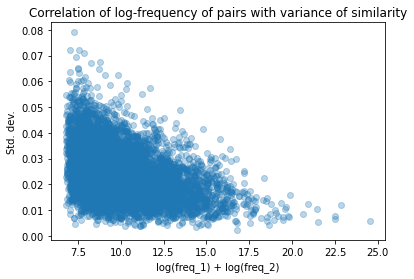

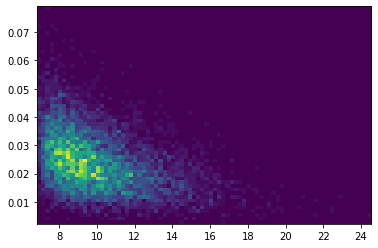

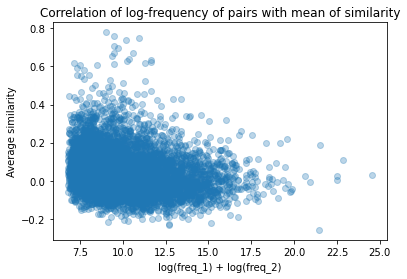

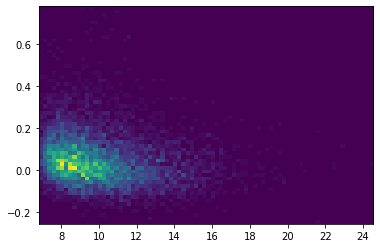

In [127]:
sims = np.array(similarity).reshape((num_groups,len(pairs)))
m = np.mean(sims, axis=0)
s = np.std(sims, axis=0)
counts_np = np.array([np.log(counts[pair[0]] * counts[pair[1]]) for pair in pairs])

print(f"Mean and std. dev of pair similarity across {num_groups} different models")
# for i in range(len(pairs)):
#     print(m[i], s[i], pairs[i]) 
    
plt.scatter(counts_np, s, alpha=0.3)
plt.title('Correlation of log-frequency of pairs with variance of similarity')
plt.xlabel('log(freq_1) + log(freq_2)')
plt.ylabel('Std. dev.')
plt.show()

heatmap, xedges, yedges = np.histogram2d(counts_np, s, bins=(80,60))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, aspect='auto', origin='lower')
plt.show()

plt.scatter(counts_np, m, alpha=0.3)
plt.title('Correlation of log-frequency of pairs with mean of similarity')
plt.xlabel('log(freq_1) + log(freq_2)')
plt.ylabel('Average similarity')
plt.show()

heatmap, xedges, yedges = np.histogram2d(counts_np, m, bins=(80,60))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, aspect='auto', origin='lower')
plt.show()


### Analysis of most similar words to abortion for different parties

In [122]:
model = Word2Vec.load('../models/lipadmodel_3_1_rolling')

In [123]:
l = [word[0] for word in model.wv.most_similar('abort_1990_NDP', topn=150) if ("abort_" not in word[0])]
for i in l:
    print(i, model.wv.similarity(i, 'abort_1990_NDP'))

Créditiste 0.6133155
termination_pregnancy 0.59061176
unwanted_pregnancies 0.5862217
nontherapeutic 0.5843111
Québécois 0.5808617
assisted_suicide 0.5730635
abortionist 0.5574062
Credit 0.54917663
euthanasia 0.5460096
recriminalization 0.5447303
birth_control 0.53609896
homosexuality 0.5325554
reproductive_choice 0.53135085
polygamy 0.5266168
therapeutic 0.5265021
pregnant_woman 0.5260543
contraception 0.5120037
recriminalize 0.5113069
unwanted_pregnancy 0.5091585
pregnancies 0.50761294
assisted_dying 0.49974412
physicianassisted_suicide 0.49459037
criminalization 0.49313816
sex_marriage 0.49176583
Labour 0.48890105
first_trimester 0.483123
womans_choice 0.47768384
sexselective 0.47708887
use_heroin 0.4770609
